In [24]:
import arviz as az
import pymc as pm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from functools import partial
from scipy.stats import norm, halfnorm

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")

%matplotlib inline

Linear regression model predicting variable $Y \sim \mathcal{N}(\mu, \sigma^2)$ where

$$
\mu = \alpha + \beta_1X_1 + \beta_2X_2
$$

$\sigma$ represents the error of the model. The outcomes $Y$ can be also defined as
$Y = \mu + \epsilon$ where $\epsilon \sim \mathcal{N}(0, \sigma^2)$ which gets us

$$
Y = \alpha + \beta_1X_1 + \beta_2X_2 + \epsilon
$$

Prior distributions of the model parameters $\alpha$, $\beta_i$, $\sigma$:

$$
\alpha \sim \mathcal{N}(0, 100) \\
\beta_i \sim \mathcal{N}(0, 100) \\
\alpha \sim \mathopen|\mathcal{N}(0, 100)\mathclose|
$$

Variance of 100 indicates weak priors.


In [4]:
np.random.seed(0)

n = 100

X_1 = np.random.randn(n)
X_2 = np.random.randn(n) * 0.2

# true parameters
sigma = 1
alpha = 1
beta_1 = 1
beta_2 = 2.5

Y = alpha + beta_1 * X_1 + beta_2 * X_2 + np.random.randn(n) * sigma

In [7]:
model = pm.Model()

with model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    # normal distribution bounded by zero
    sigma = pm.HalfNormal("sigma", sigma=1)
    
    # expected value of Y
    mu = alpha * beta[0] * X_1 + beta[1] * X_2
    
    # likelihood (sampling distribution of Y) = p(Y|model params)
    # that's why we use the observed=Y argument
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)
    
    

In [8]:
with model:
    inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 299 divergences after tuning. Increase `target_accept` or reparameterize.


In [10]:
inference

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

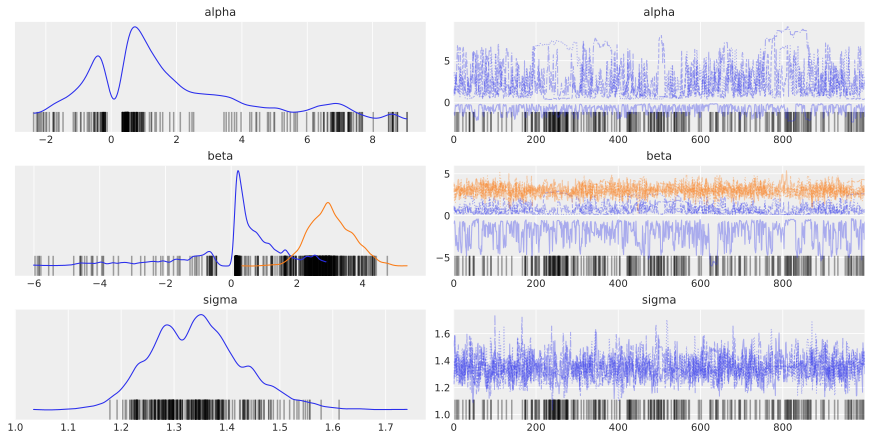

In [93]:
az.style.use("arviz-darkgrid")
az.plot_trace(inference, combined=True)
plt.show()

In [14]:
az.summary(inference, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.84,2.50,-1.85,7.11,0.79,0.58,7.09,33.66,1.58
beta[0],0.11,1.57,-3.23,2.80,0.64,0.48,7.08,31.72,1.58
beta[1],3.03,0.65,1.92,4.33,0.03,0.02,593.21,1310.33,1.01
sigma,1.35,0.09,1.19,1.51,0.00,0.00,579.34,1733.94,1.01


### Dumb and Doesn't Work
But it should?

In [89]:
def prior_by_likelihood(
    alpha: float,
    beta_1: float,
    beta_2: float,
    sigma: float,
    X_1: np.array,
    X_2: np.array,
    Y: np.array,
) -> float:
    
    scale_10_norm = norm(loc=0, scale=10)
    p_alpha = scale_10_norm.pdf(alpha)
    p_beta_1 = scale_10_norm.pdf(beta_1)
    p_beta_2 = scale_10_norm.pdf(beta_1)
    p_sigma = halfnorm(scale=1).pdf(sigma)
    
    prior = p_alpha * p_beta_1 * p_beta_2 * p_sigma
        
    mu = alpha * beta_1 * X_1 + beta_2 * X_2
    
    p_Y_obs = [
        norm(loc=mu_i, scale=sigma).pdf(Y_i)
        for mu_i, Y_i in zip(mu, Y)
    ]
    
    # p_Y_obs = norm(loc=mu, scale=sigma).pdf(Y)
        
    likelihood = np.prod(p_Y_obs)
    
    return prior * likelihood

In [79]:
def propose(current: np.array) -> np.array:
    n_params = len(current)
    mean = np.zeros(n_params)
    covariance = np.eye(n_params)
    proposed_delta = np.random.multivariate_normal(mean, covariance)
    return np.clip(current + proposed_delta, 0, 1)


def metropolis_sampling(
    pdf: callable,
    start: np.array,
    steps: int,
) -> np.array:
    
    samples = [start]

    for _ in range(steps):
        current = samples[-1]
        proposal = propose(current)
        args = proposal.tolist()
        prob_move = min(pdf(*proposal) / pdf(*current), 1)

        if np.random.rand() < prob_move:
            samples.append(proposal)
        else:
            samples.append(current)

    return np.array(samples)

In [90]:
pdf = partial(
    prior_by_likelihood,
    X_1=X_1,
    X_2=X_2,
    Y=Y,

)

start = np.array([0, 0, 0, 0,])
start = np.array([1.5, 1.5, 2.0, 1.5])

samples = metropolis_sampling(pdf, start, 100)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


In [92]:
pd.DataFrame(samples, columns=["alpha", "beta_1", "beta_2", "sigma"]).describe()

,alpha,beta_1,beta_2,sigma
count,101.000000,101.000000,101.000000,101.000000
mean,1.009901,1.009901,1.018491,1.009901
std,0.070007,0.070007,0.140324,0.070007
min,1.000000,1.000000,0.969964,1.000000
25%,1.000000,1.000000,0.999441,1.000000
50%,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000
max,1.500000,1.500000,2.000000,1.500000
